# HMM

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bidict

import literate
import HMM2 as HMM

In [2]:
syldict = literate.syldict("data/Syllable_dictionary.txt")
data, words = literate.read("data/shakespeare.txt", syldict)
rhymes = literate.get_rhymes(data)

print(len(data), "sonnets\n",
      len(words), "unique words\n",
      len(syldict), "words in dictionary\n",
      len(rhymes), "rhyming words")

154 sonnets
 3205 unique words
 3205 words in dictionary
 1015 rhyming words


In [3]:
wmap = bidict.bidict(enumerate(words)).inv

In [4]:
def toNum(wmap, words):
    return [wmap[w] for w in words]

def toWord(wmap, nums):
    return [wmap.inv[i] for i in nums]

def squash(sonnet):
    return [w for l in sonnet for w in l]

nummed = [toNum(wmap, squash(s)) for s in data]

## Training

In [5]:
nstates = [2,4,8,12,16]
hmms = []
curves = []
for n in nstates:
    print("STATES", n)
    hmm,s = HMM.unsupervised(nummed, N_iters=20, n_states=n)
    hmms.append(hmm)
    curves.append(s)
hmm = hmms[-1]

STATES 2
Training 20 iters
1  3  5  7  9  11  13  15  17  19  
elapsed 35.477242946624756
STATES 4
Training 20 iters
1  3  5  7  9  11  13  15  17  19  
elapsed 52.75578570365906
STATES 8
Training 20 iters
1  3  5  7  9  11  13  15  17  19  
elapsed 86.21017265319824
STATES 12
Training 20 iters
1  3  5  7  9  11  13  15  17  19  
elapsed 116.62624835968018
STATES 16
Training 20 iters
1  3  5  7  9  11  13  15  17  19  
elapsed 152.58291482925415


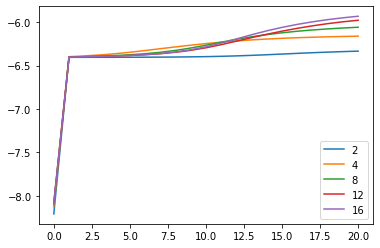

In [8]:
for i,c in zip(nstates,curves):
    plt.plot(c, label=i)
plt.legend()

In [ ]:
# scores = np.array([])
# hmm = HMM.init_rand(10, len(words))

In [ ]:
# hmm,s = HMM.unsupervised(nummed, N_iters=10, hmm=hmm)
# scores = np.concatenate([scores, s])
# plt.plot(scores)

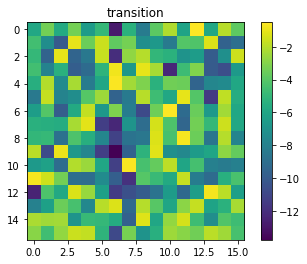

In [9]:
plt.title("transition")
plt.imshow(np.log(hmm.A))
#plt.imshow(hmm.A)
plt.colorbar()

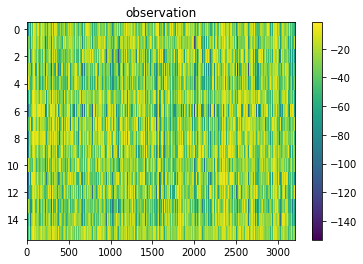

In [10]:
plt.title("observation")
plt.imshow(np.log(hmm.O), aspect='auto')
#plt.imshow(hmm.O, aspect='auto')
plt.colorbar()

In [11]:
HMM.probability_alphas(hmm, nummed[0], log=True)

-638.3945738127737

## Generation

In [12]:
em, st = HMM.generate_emission(hmm, 140)

def sonnetify(wmap, syldict, ids):
    """take string of word ids,
    convert them to words,
    and break lines every 10 ish syllables
    """
    sonnet = []
    line = []
    syls = 0
    for i in ids:
        word = wmap.inv[i]
        syls += abs(syldict[word][0])
        line.append(word)
        if (syls >= 10):
            sonnet.append(line)
            line = []
            syls = 0
            if (len(sonnet) == 14):
                break
    return sonnet

literate.recite(sonnetify(wmap, syldict, em))

song with all the my grow'st nature first of
eye and world cloud to beauty acknowledge
life my desiring like that siren it
delights his be still my to fire for they
thy worth where and dumb enough rich i whose
not untrue sought do every harmful fleece
earth breath heart there his ceremony a
give by in or pay and let i set youth
and and am cannot not the for i my
there excellence wanting thee is of badness
that sweet force devour mistress seemed but far
little of give either's though seals hell in
miles why moon most all one thou modern care
but each the drown be faults come deserving the


In [13]:
def wordmask(wmap, condition):
    """creates a len(words) array that is True
    for words satisfing the condition
    """
    mask = np.repeat(False, len(wmap))
    filtered = [wmap[w] for w in wmap if condition(w)]
    mask[filtered] = True
    return mask
    

In [14]:
def generate_sonnet(hmm, wmap, rhymes, syldict):
    '''
    Generates sonnet using hmm

    Returns:
        emission:   The randomly generated sonnet as a list of words
    '''
    state = np.random.choice(hmm.L, p=hmm.A0)
    
    # functions to filter down allowable words
    def fewersyls(n, w):
        return abs(syldict[w][0]) < n
    def hassyls(n, w):
        return abs(syldict[w][0]) == n
    def rhymable(w):
        return len(rhymes[w]) > 0
    def rhymeswith(word, w):
        return w in rhymes[word]
    
    def try_line(state, rhymeword=None, maxwords=20):
        """Generate new line starting with given state,
        having 10 syllables, ending on a rhymable word if rhymeword is None,
        and ending on a rhyme with rhymeword if it is a string.
        It unfortunately often gets stuck generating th'.
        """
        syls = 10
        line = []
        while (syls > 0):
            if (len(line) > maxwords):
                break
            # if a word either has few enough syllables to not end the line,
            # or ends the line and satisfies the rhyme scheme.
            # If there is no rhymeword, it must be rhymable, otherwise,
            # it must rhyme with rhymeword.
            sylrhyme = lambda w: fewersyls(syls, w)\
                or (hassyls(syls, w) and (rhymeswith(rhymeword, w) if rhymeword else rhymable(w)))
            
            # filter out words by setting their probabilities to zero
            pobs = hmm.O[state].copy()
            pobs[~wordmask(wmap, sylrhyme)] = 0
            pobs /= pobs.sum()

            # pick new word and state
            word = wmap.inv[np.random.choice(hmm.D, p=pobs)]
            state = np.random.choice(hmm.L, p=hmm.A[state])
            line.append(word)
            syls -= abs(syldict[word][0])
            #print(syls, word, rhymeword, sum(pobs!=0))
        return state, line
    
    def generate_line(state0, rhymeword=None, maxwords=20, tries=100):
        """Keeps re-running try_line until it generates something valid"""
        for _ in range(tries):
            state, line = try_line(state0, rhymeword, maxwords)
            if (len(line) < maxwords):
                return state,line
        # we tried our best
        return state,line

    sonnet = []
    # make three quadtrains, with rhyme scheme abab
    for q in range(3):
        state, line = generate_line(state)
        sonnet.append(line)
        state, line = generate_line(state)
        sonnet.append(line)
        state, line = generate_line(state, sonnet[-2][-1])
        sonnet.append(line)
        state, line = generate_line(state, sonnet[-2][-1])
        sonnet.append(line)
    # and a rhyming couplet
    state, line = generate_line(state)
    sonnet.append(line)
    state, line = generate_line(state, sonnet[-1][-1])
    sonnet.append(line)

    return sonnet

In [15]:
sonnet = generate_sonnet(hmm, wmap, rhymes, syldict)
literate.recite(sonnet)

of than how believe my from my to show
old and both my with no longer memory
no their flame their in of bends thou of grow
sail if his such when but not looks can die
he not lies to aye me better of be day
thou for before the fearful self thy i
and lies heaven will birds the end thee still th' stay
thou luck see me himself mine truth so lie
sail thee case that in under so i night
beauty's cars what celestial flies full fight
that art my life things speed a black for write
show over still child if fair with blow quite
the millions hammered be so nature not
kept of my should permit be weakness th' th' th' blot


## visualization

In [16]:
def top_words(wmap, hmm, n=10):
    ids = np.argsort(hmm.O, axis=1)[:,-n:]
    words = [
        [wmap.inv[w] for w in s]
        for s in ids
    ]
    return words, np.sort(hmm.O, axis=1)[:,-n:]

In [17]:
top, topprob = top_words(wmap, hmm)

In [18]:
literate.recite(top)

nothing should you then in heart love self i to
it for life which from but a with all to
most then am which they thy and that do i
me my this be thy no his that thou the
so and his a by for is thou of the
being to these her she o hath is from in
if hast why day fair thou art world thy in
give o or still is eyes beauty eye on nor
not thy time more my every love i in to
by sweet thy for this when my that i and
which thou with to or a it mine doth of
be are not love so your with thee thy my
were shall like by thee make to all me as
thou in so be and those the a me but
be me with not for my so that and of
like do yet i that when see to not in


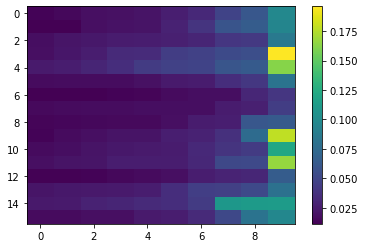

In [19]:
plt.imshow(topprob, aspect="auto")
plt.colorbar()